#### 以 Python 進行 S&P 500 指數的時間序列 EDA、技術分析與預測模型建構

包含：

- 資料讀取與基本資訊
- 移動平均線（MA20 / MA60 / MA120）
- 波動率分析（Rolling Standard Deviation）
- 報酬率分布與自相關分析（ACF / PACF）
- 重大事件分析：2008 金融海嘯、2020 COVID-19
- K 線圖（Candlestick Chart）
- 技術指標：RSI、MACD、Bollinger Bands
- 時間序列預測模型：ARIMA / Prophet / LSTM



## 安裝相關套件



In [ ]:
!pip install --upgrade prophet
!pip install mplfinance

# 資料讀取與基本資訊

In [1]:
import pandas as pd

df = pd.read_csv('sp500_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(df.head())
print(df.describe())
print(df.isna().sum())

                        Date        Open        High         Low       Close  \
0  1990-01-02 00:00:00-05:00  353.399994  359.690002  351.980011  359.690002   
1  1990-01-03 00:00:00-05:00  359.690002  360.589996  357.890015  358.760010   
2  1990-01-04 00:00:00-05:00  358.760010  358.760010  352.890015  355.670013   
3  1990-01-05 00:00:00-05:00  355.670013  355.670013  351.350006  352.200012   
4  1990-01-08 00:00:00-05:00  352.200012  354.239990  350.540009  353.790009   

      Volume  
0  162070000  
1  192330000  
2  177000000  
3  158530000  
4  140110000  
              Open         High          Low        Close        Volume
count  8565.000000  8565.000000  8565.000000  8565.000000  8.565000e+03
mean   1583.568097  1592.942337  1573.574951  1583.898693  2.459029e+09
std    1089.338157  1095.204538  1083.145746  1089.516200  1.849476e+09
min     295.450012   301.450012   294.510010   295.459991  1.499000e+07
25%     894.739990   905.840027   883.020020   896.140015  6.428000e+

/tmp/ipython-input-1591059277.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


## 建立報酬率欄位

In [3]:
import numpy as np
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = (df['Close'] / df['Close'].shift(1)).apply(lambda x: np.log(x))

#### 移動平均線（MA20 / MA60 / MA120）
使用簡單移動平均線（Simple Moving Average, SMA）觀察長中短期趨勢

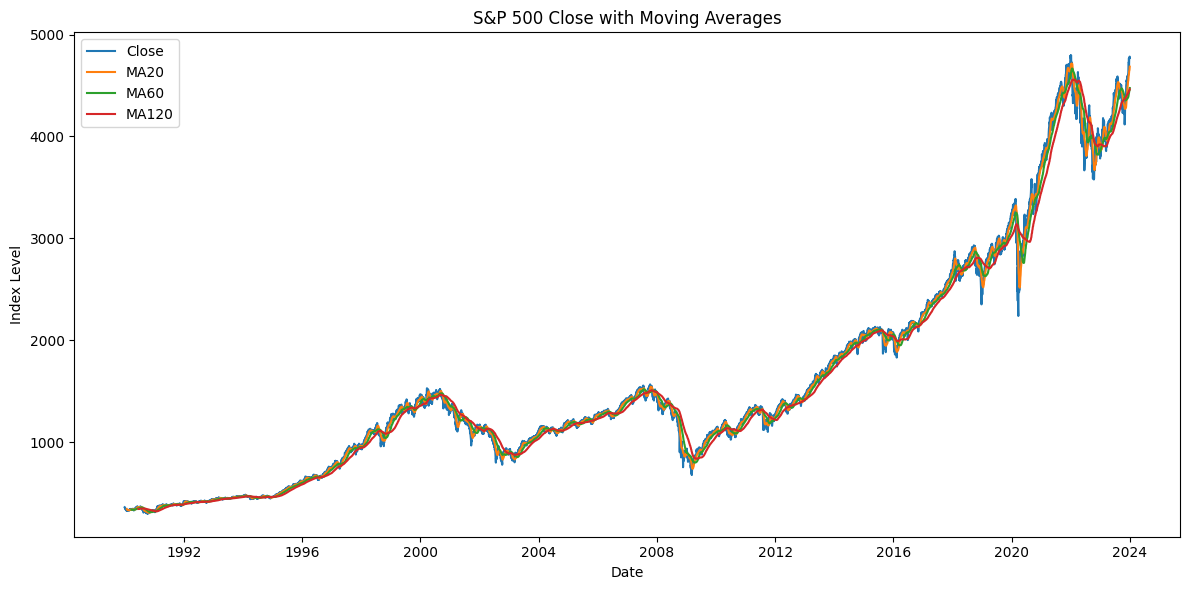

In [4]:
import matplotlib.pyplot as plt

df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA60'] = df['Close'].rolling(window=60).mean()
df['MA120'] = df['Close'].rolling(window=120).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA20'], label='MA20')
plt.plot(df['Date'], df['MA60'], label='MA60')
plt.plot(df['Date'], df['MA120'], label='MA120')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.title('S&P 500 Close with Moving Averages')
plt.tight_layout()
plt.show()

#### 波動率分析：Rolling Standard Deviation

以 滾動標準差 量化報酬率的波動程度，常見視窗例如 20 日（約一個交易月）。

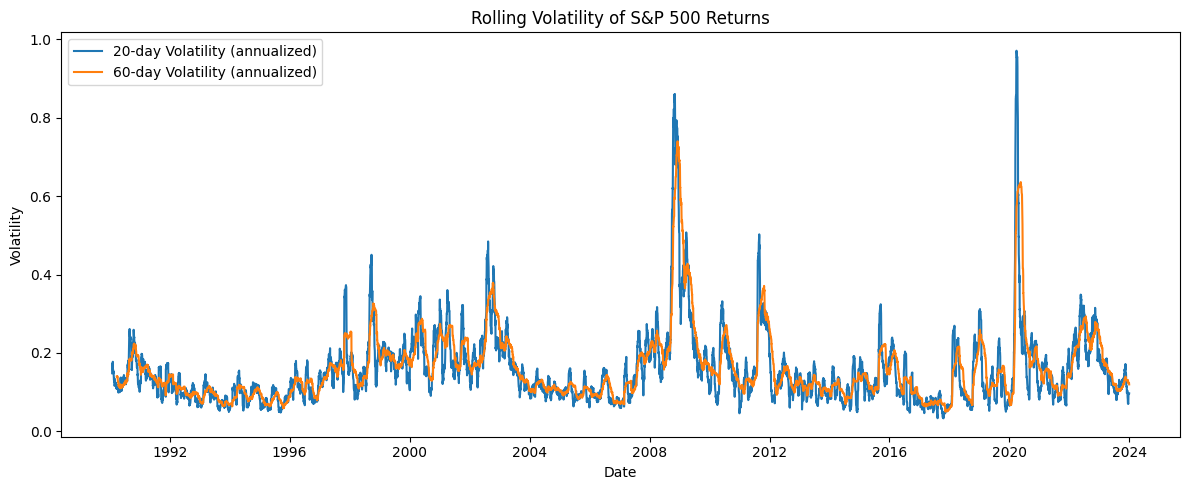

In [5]:
import numpy as np
df['Volatility20'] = df['Return'].rolling(window=20).std() * np.sqrt(252)
df['Volatility60'] = df['Return'].rolling(window=60).std() * np.sqrt(252)

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Volatility20'], label='20-day Volatility (annualized)')
plt.plot(df['Date'], df['Volatility60'], label='60-day Volatility (annualized)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rolling Volatility of S&P 500 Returns')
plt.tight_layout()
plt.show()

## 報酬率直方圖與常態分布近似

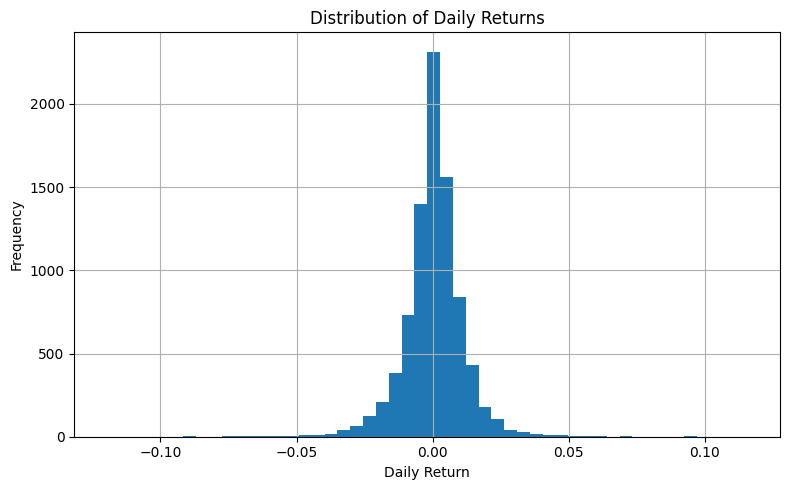

In [6]:
plt.figure(figsize=(8, 5))
df['Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Distribution of Daily Returns')
plt.tight_layout()
plt.show()

### ACF/PACF
- Autocorrelation function (ACF)
- partial autocorrelation function (PACF)
- 自相關和局部自相關用於測量目前數列值和過去數列值之間的相關性，並指示預測將來值時最有用的過去數列值。
- 瞭解了此內容，您就可以確定 ARIMA 模型中過程的順序。

- 自相關函數 (ACF)。延遲為 k 時，這是相距 k 個時間間隔的數列值之間的相關性。
- 局部自相關函數 (PACF)。延遲為 k 時，這是相距 k 個時間間隔的數列值之間的相關性，用來說明它們之間的時間間隔值。

檢測資料自身的相關性，分別是 自我相關係數 與 偏自我相關係數

https://www.geeksforgeeks.org/r-machine-learning/autocorrelation-and-partial-autocorrelation/

<Figure size 1000x400 with 0 Axes>

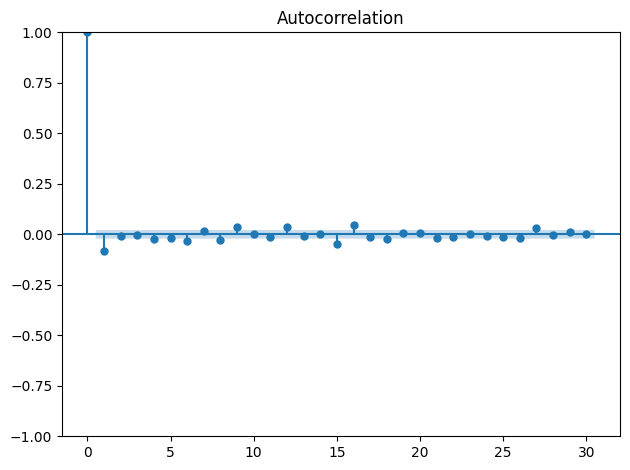

<Figure size 1000x400 with 0 Axes>

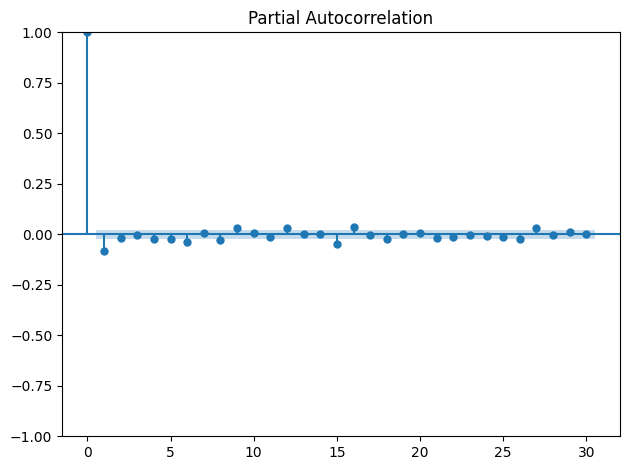

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

returns = df['Return'].dropna()

plt.figure(figsize=(10, 4))
plot_acf(returns, lags=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(returns, lags=30, method='ywm')
plt.tight_layout()
plt.show()

# 重大事件分析：2008 金融海嘯與 2020 COVID-19

#### 2008 金融海嘯期間

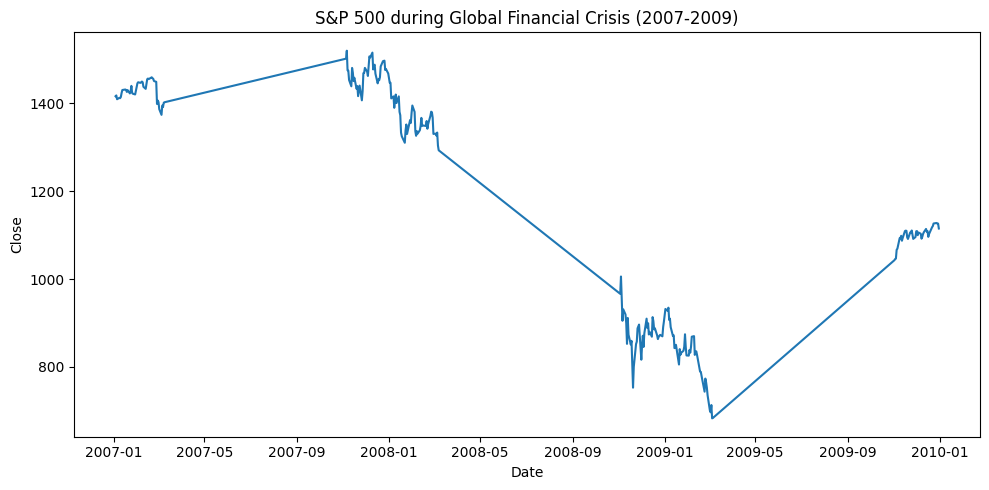

In [12]:
# 確保 'Date' 欄位是日期時間類型，然後移除時區以便於比較
df_date_cleaned = pd.to_datetime(df['Date'], errors='coerce')
if df_date_cleaned.dt.tz is not None:
    df_date_cleaned = df_date_cleaned.dt.tz_localize(None)

mask_2008 = (df_date_cleaned >= pd.to_datetime('2007-01-01')) & \
            (df_date_cleaned <= pd.to_datetime('2009-12-31'))
df_2008 = df[mask_2008]

plt.figure(figsize=(10, 5))
plt.plot(df_2008['Date'], df_2008['Close'])
plt.title('S&P 500 during Global Financial Crisis (2007-2009)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.tight_layout()
plt.show()

#### 2020 COVID-19 疫情期間

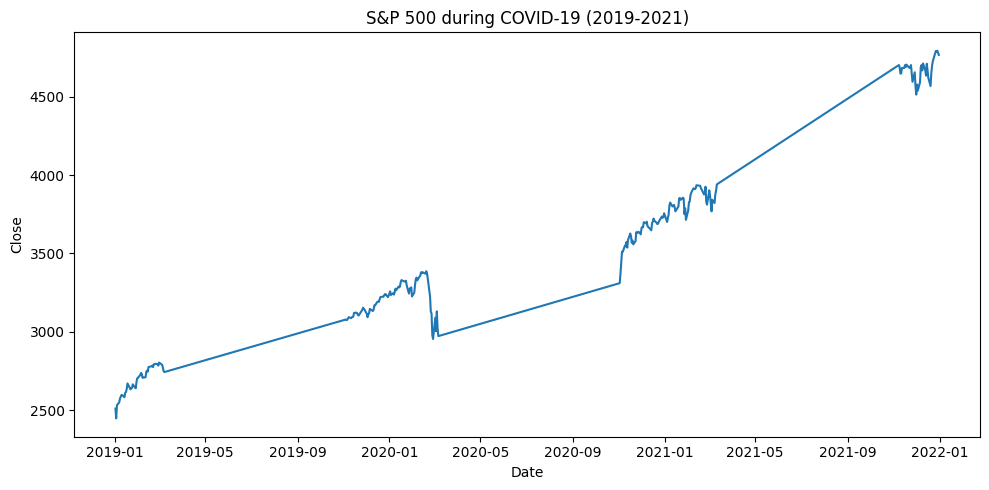

In [15]:
# 確保 'Date' 欄位是日期時間類型，然後移除時區以便於比較
df_date_cleaned_2020 = pd.to_datetime(df['Date'], errors='coerce')
if df_date_cleaned_2020.dt.tz is not None:
    df_date_cleaned_2020 = df_date_cleaned_2020.dt.tz_localize(None)

mask_2020 = (df_date_cleaned_2020 >= pd.to_datetime('2019-01-01')) & (df_date_cleaned_2020 <= pd.to_datetime('2021-12-31'))
df_2020 = df[mask_2020]

plt.figure(figsize=(10, 5))
plt.plot(df_2020['Date'], df_2020['Close'])
plt.title('S&P 500 during COVID-19 (2019-2021)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.tight_layout()
plt.show()

#### K 線圖（Candlestick Chart）
使用 mplfinance 套件繪製 K 線圖

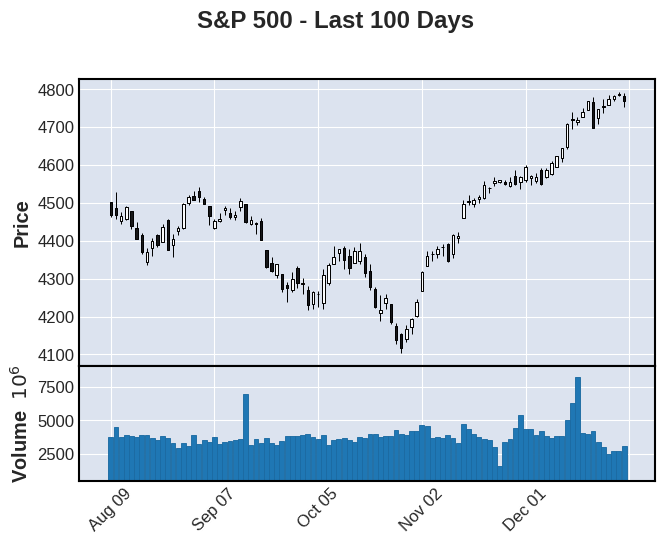

In [22]:
import mplfinance as mpf
import pandas as pd

df_ohlc = df.set_index('Date')[['Open', 'High', 'Low', 'Close', 'Volume']]

# 將索引明確轉換為 DatetimeIndex，並處理可能存在的時區問題
# 使用 utc=True 確保將所有日期時間轉換為 UTC 時區的 DatetimeIndex
df_ohlc.index = pd.to_datetime(df_ohlc.index, utc=True)

# 移除時區資訊，使其成為時區無關的 DatetimeIndex，以符合 mplfinance 的要求
df_ohlc.index = df_ohlc.index.tz_localize(None)

mpf.plot(df_ohlc.tail(100), type='candle', volume=True, title='S&P 500 - Last 100 Days')

#### 技術指標：RSI

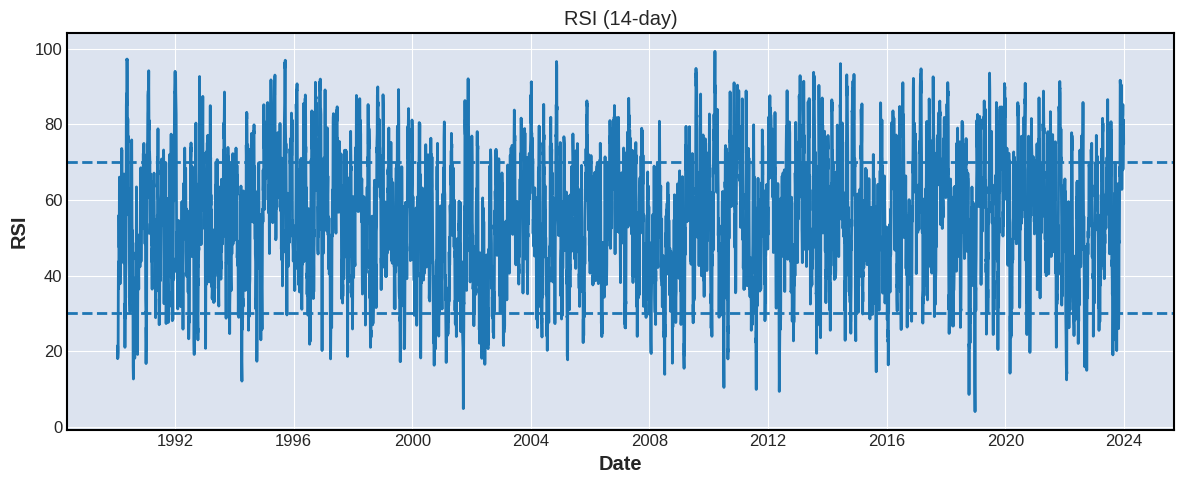

In [23]:
window_rsi = 14
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=window_rsi).mean()
avg_loss = loss.rolling(window=window_rsi).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['RSI'])
plt.axhline(70, linestyle='--')
plt.axhline(30, linestyle='--')
plt.title('RSI (14-day)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.tight_layout()
plt.show()

#### 技術指標：MACD（Moving Average Convergence Divergence）

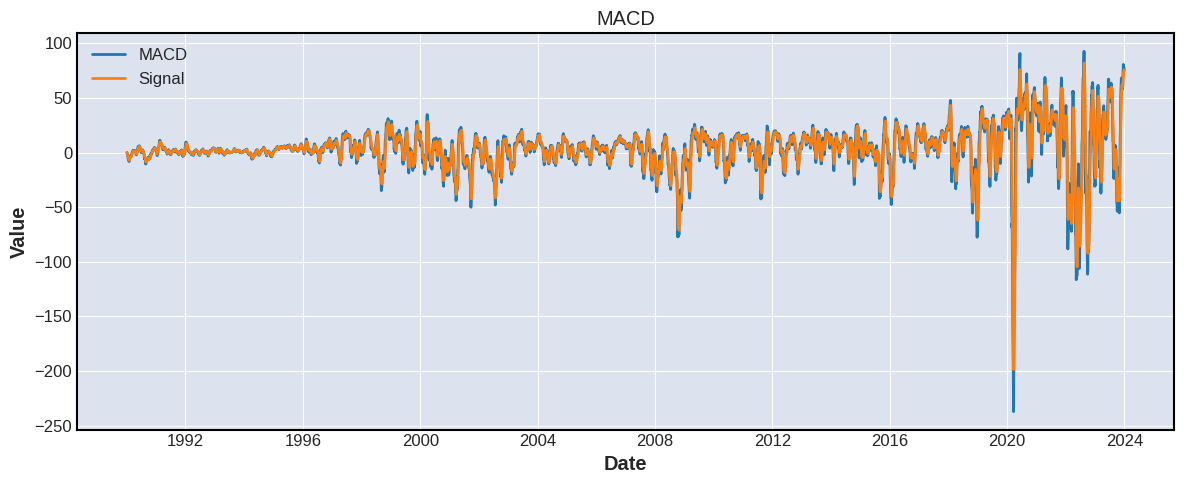

In [24]:
short_span = 12
long_span = 26
signal_span = 9

df['EMA12'] = df['Close'].ewm(span=short_span, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=long_span, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_signal'] = df['MACD'].ewm(span=signal_span, adjust=False).mean()

plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['MACD'], label='MACD')
plt.plot(df['Date'], df['MACD_signal'], label='Signal')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('MACD')
plt.legend()
plt.tight_layout()
plt.show()

#### 技術指標： Bollinger Bands

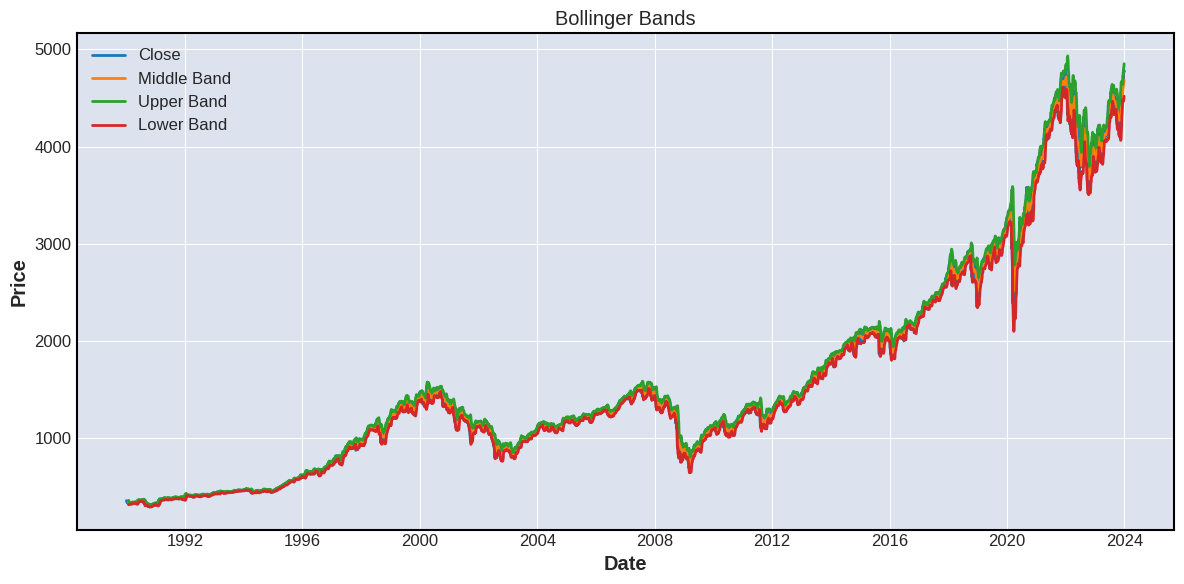

In [25]:
window_bb = 20
df['BB_MID'] = df['Close'].rolling(window=window_bb).mean()
df['BB_STD'] = df['Close'].rolling(window=window_bb).std()
df['BB_UPPER'] = df['BB_MID'] + 2 * df['BB_STD']
df['BB_LOWER'] = df['BB_MID'] - 2 * df['BB_STD']

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['BB_MID'], label='Middle Band')
plt.plot(df['Date'], df['BB_UPPER'], label='Upper Band')
plt.plot(df['Date'], df['BB_LOWER'], label='Lower Band')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bollinger Bands')
plt.tight_layout()
plt.show()

# 時間型序列預測模：ARIMA

/tmp/ipython-input-2225990960.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_series = df.set_index('Date')['Close'].asfreq('B').fillna(method='ffill')


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8869
Model:                 ARIMA(5, 1, 0)   Log Likelihood               27980.979
Date:                Tue, 18 Nov 2025   AIC                         -55949.958
Time:                        20:19:41   BIC                         -55907.417
Sample:                    01-02-1990   HQIC                        -55935.472
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0203      0.006     -3.610      0.000      -0.031      -0.009
ar.L2          0.0049      0.006      0.888      0.375      -0.006       0.016
ar.L3          0.0243      0.006      4.359      0.0

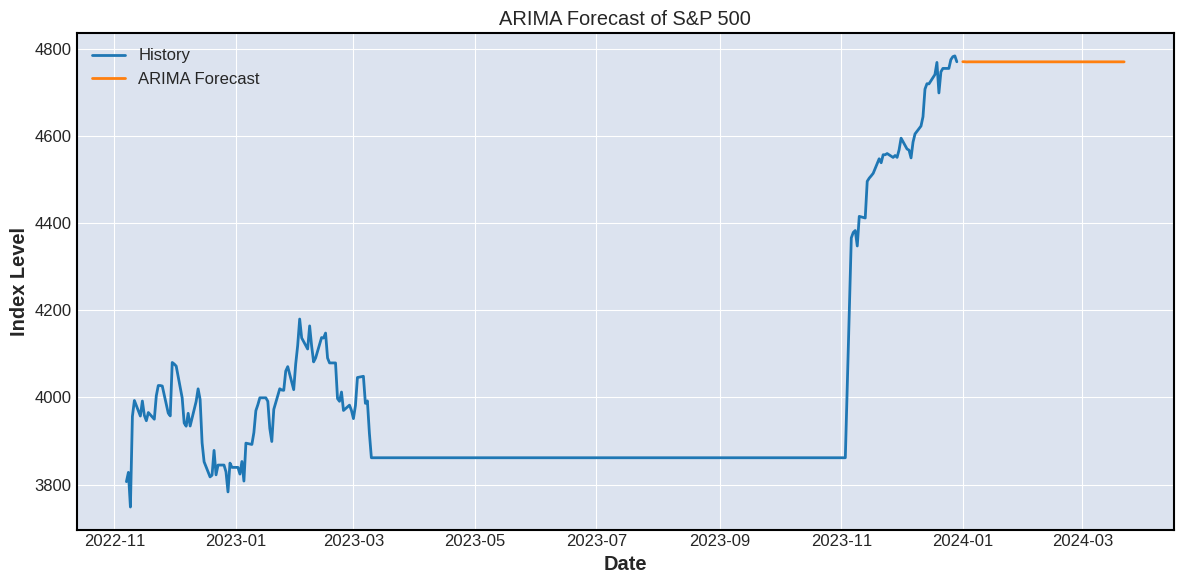

In [26]:
from statsmodels.tsa.arima.model import ARIMA

close_series = df.set_index('Date')['Close'].asfreq('B').fillna(method='ffill')
close_log = np.log(close_series)

model = ARIMA(close_log, order=(5, 1, 0))
result = model.fit()
print(result.summary())

forecast_steps = 60
forecast_log = result.forecast(steps=forecast_steps)
forecast = np.exp(forecast_log)

plt.figure(figsize=(12, 6))
plt.plot(close_series[-300:], label='History')
plt.plot(forecast.index, forecast.values, label='ARIMA Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Index Level')
plt.title('ARIMA Forecast of S&P 500')
plt.tight_layout()
plt.show()

# 時間型序列預測模： 8.2 Prophet 模型

- Prophet 是由Facebook開發的一個開源時間序列預測庫
- 設計考慮了業務場景中的時間序列特點，如季節性變化、假日效應和趨勢變化。
- Prophet 特別適合處理日級別（或以上頻率）的時間序列數據，並且在處理缺失數據和異常值方面表現出色

https://facebook.github.io/prophet/

`GITHUB`[Prophet: Automatic Forecasting Procedure](https://github.com/facebook/prophet)

https://peerj.com/preprints/3190/

https://www.cnblogs.com/wt11/collections/1524

https://zhuanlan.zhihu.com/p/680771050

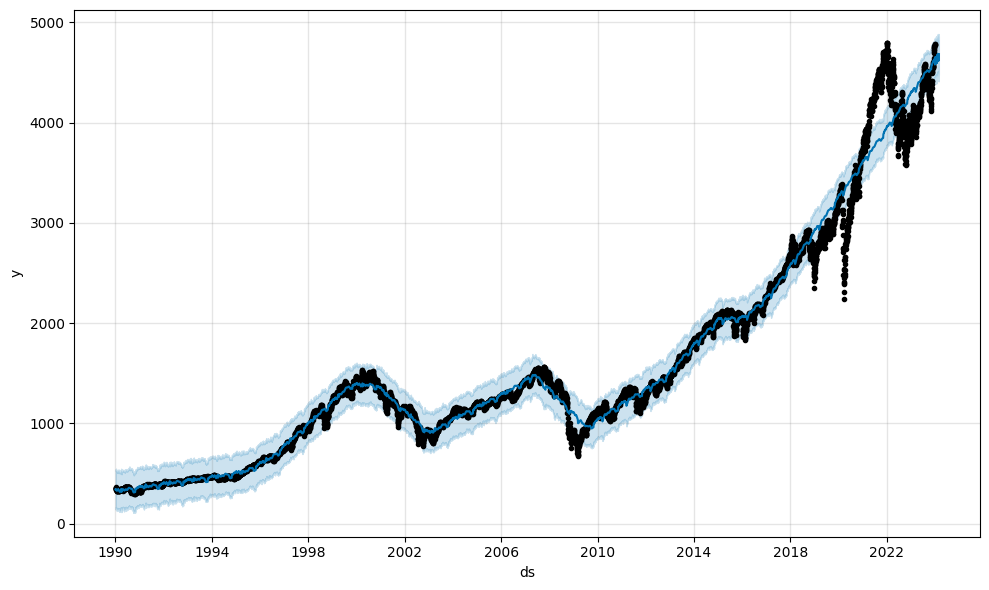

In [2]:
from prophet import Prophet
import pandas as pd

# 重新定義 df，以確保在核心重置或前一個儲存格未執行時其可用。
# 此程式碼改編自初始數據載入儲存格 (7HU3phRclpGT)。
df = pd.read_csv('sp500_data.csv')
df['Date'] = pd.to_datetime(df['Date'], utc=True) # 轉換為 UTC 以保持一致性
df['Date'] = df['Date'].dt.tz_localize(None) # 移除時區資訊，因為 Prophet 預期無時區日期時間
df = df.sort_values('Date').reset_index(drop=True)

df_prophet = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
m = Prophet(daily_seasonality=True)
m.fit(df_prophet)
future = m.make_future_dataframe(periods=60)
forecast = m.predict(future)
fig = m.plot(forecast)

# 時間型序列預測模： LSTM 深度學習模型

此示範使用 Keras 建立簡單的單變量 LSTM 模型，以收盤價預測未來值。

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

close_values = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_values)

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_close)):
    X.append(scaled_close[i - lookback:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=32)

# 進行未來幾步預測（示意）
last_seq = scaled_close[-lookback:]
last_seq = last_seq.reshape((1, lookback, 1))
pred_scaled = model.predict(last_seq)
pred_price = scaler.inverse_transform(pred_scaled)
print('預測下一期價格：', pred_price[0, 0])


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


266/266 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.0085
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 1.4958e-04
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 1.4021e-04
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 1.1551e-04
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - loss: 1.0093e-04
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 1.4238e-04
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 7.9518e-05
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - loss: 8.8130e-05
Epoch 9/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 8.3692e-05
Epoch 10/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 7.2463e-05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
預測下一期價格： 4777.956
